In [22]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.cuda.amp import GradScaler, autocast

In [23]:
# Dataset Class with Bounding Box Normalization
class WasteDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.annotations = self.annotations.dropna(subset=["label"]).reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        row = self.annotations.iloc[idx]
        img_path = os.path.join(self.image_dir, row["query"], row["image"])
        image = Image.open(img_path).convert("RGB")
        
        # Load label
        label = int(row["label"])
        
        # Load bounding box and normalize
        if label == 1:
            width, height = image.size
            bounding_box = torch.tensor([
                row["startX"] / width,
                row["startY"] / height,
                row["endX"] / width,
                row["endY"] / height
            ], dtype=torch.float32)
        else:
            bounding_box = torch.zeros(4, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return {"image": image, "label": label, "bounding_box": bounding_box}

In [24]:
# Model Definition
class WasteDetectionModel(nn.Module):
    def __init__(self, num_classes=20):
        super(WasteDetectionModel, self).__init__()
        # Load ResNet-34 as the backbone
        self.backbone = models.resnet34(pretrained=True)
        
        # Remove the fully connected layer and retain feature extraction
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Classifier for waste classification
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, num_classes)  # ResNet-34 outputs 512 features
        )

        # Bounding box regressor
        self.bbox_regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 4),
            nn.Sigmoid()  # Ensure output is in [0, 1]
        )

    def forward(self, x):
        # Extract features using the backbone
        features = self.backbone(x)
        # Apply global average pooling
        pooled_features = self.avgpool(features)

        # Compute class logits
        class_logits = self.classifier(pooled_features)
        # Compute bounding box coordinates
        bbox_coords = self.bbox_regressor(pooled_features)

        return class_logits, bbox_coords

In [25]:
# Training Function
def train_model():
    csv_file = "Train-Data.csv"
    image_dir = "Image-Files"
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
    ])
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    dataset = WasteDataset(csv_file, image_dir, transform)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)

    model = WasteDetectionModel(num_classes=20).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    criterion_class = nn.CrossEntropyLoss()
    criterion_bbox = nn.SmoothL1Loss()

    scaler = GradScaler()  # Mixed Precision Training
    num_epochs = 5
    bbox_loss_weight = 1  # Weight for bounding box loss

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch in dataloader:
            images = batch["image"].to(device)
            labels = batch["label"].to(device)
            bbox_targets = batch["bounding_box"].to(device)

            optimizer.zero_grad()
            with autocast():  # Enable mixed precision
                class_logits, bbox_coords = model(images)
                loss_class = criterion_class(class_logits, labels)
                loss_bbox = criterion_bbox(bbox_coords, bbox_targets)
                loss = loss_class + bbox_loss_weight * loss_bbox

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        scheduler.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Classification Loss: {loss_class.item():.4f}, Bounding Box Loss: {loss_bbox.item():.4f}")

    return model

In [26]:
# Train the model
trained_model = train_model()

C:\Users\manoj\Downloads\New folder\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\manoj\Downloads\New folder\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\manoj/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|█████████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:34<00:00, 2.50MB/s]
C:\Users\manoj\AppData\Local\Temp\ipykernel_4024\1053656748.py:23: FutureWarning: `torc

Epoch [1/5], Classification Loss: 0.9002, Bounding Box Loss: 0.0650
Epoch [2/5], Classification Loss: 1.1156, Bounding Box Loss: 0.0332
Epoch [3/5], Classification Loss: 0.0811, Bounding Box Loss: 0.0195
Epoch [4/5], Classification Loss: 0.6035, Bounding Box Loss: 0.0523
Epoch [5/5], Classification Loss: 0.0098, Bounding Box Loss: 0.0093


In [27]:
from sklearn.metrics import f1_score

# Function to calculate F1-Measure
def calculate_f1(true_labels, predicted_labels):
    """
    Calculate F1-Measure for classification task.
    Args:
        true_labels (list): Ground truth class labels.
        predicted_labels (list): Predicted class labels.
    Returns:
        float: F1-Measure score.
    """
    f1 = f1_score(true_labels, predicted_labels, average="weighted")
    return f1

# Function to calculate IoU
def calculate_iou(boxA, boxB):
    """
    Calculate the Intersection over Union (IoU) for two bounding boxes.
    Args:
        boxA (tensor): Predicted bounding box [x1, y1, x2, y2].
        boxB (tensor): Ground truth bounding box [x1, y1, x2, y2].
    Returns:
        float: IoU value.
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Intersection area
    inter_width = max(0, xB - xA)
    inter_height = max(0, yB - yA)
    interArea = inter_width * inter_height
    
    # Areas of both boxes
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    # Union area
    unionArea = boxAArea + boxBArea - interArea
    
    if unionArea == 0:  # Avoid division by zero
        return 0.0
    
    return interArea / unionArea

# Evaluation function
def evaluate_model(model, dataloader):
    """
    Evaluate the model's performance on classification and bounding box regression.
    Args:
        model (nn.Module): The trained model.
        dataloader (DataLoader): DataLoader for the test dataset.
    """
    model.eval()
    all_true_labels = []
    all_predicted_labels = []
    iou_scores = []
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for batch in dataloader:
            images = batch["image"].to(device)
            true_labels = batch["label"].to(device)
            true_bboxes = batch["bounding_box"].to(device)

            class_logits, bbox_preds = model(images)

            # Get predicted labels and bounding boxes
            predicted_labels = torch.argmax(class_logits, dim=1)

            for i in range(len(images)):
                all_true_labels.append(true_labels[i].item())
                all_predicted_labels.append(predicted_labels[i].item())

                # Calculate IoU if bounding box is non-empty
                if true_bboxes[i].sum().item() > 0:  # Check if ground truth bbox is non-zero
                    iou = calculate_iou(bbox_preds[i].cpu(), true_bboxes[i].cpu())
                    iou_scores.append(iou)

    # Calculate F1-Measure
    f1 = calculate_f1(all_true_labels, all_predicted_labels)
    mean_iou = sum(iou_scores) / len(iou_scores) if iou_scores else 0.0

    print(f"F1-Measure: {f1:.4f}")
    print(f"Mean IoU: {mean_iou:.4f}")

In [28]:
# Paths to test data
test_csv_file = "Test-Data.csv"  # Replace with your actual test CSV path
test_image_dir = "Image-Files"   # Same image directory as used for training

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Convert to tensor
])

test_dataset = WasteDataset(csv_file=test_csv_file, image_dir=test_image_dir, transform=test_transform)

# Create the DataLoader for the test set
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

# Use the evaluation function
evaluate_model(trained_model, test_loader)

F1-Measure: 1.0000
Mean IoU: 0.4658


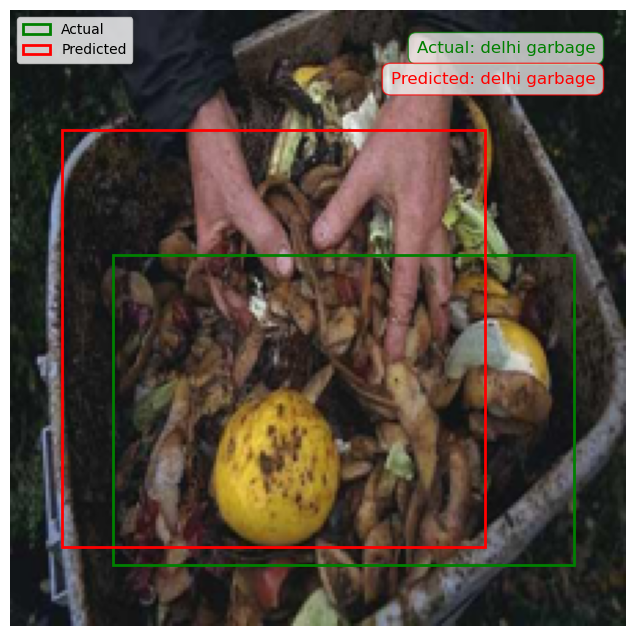

In [29]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def get_class_names(image_dir):
    """
    Get class names from folder names inside the given directory.
    
    Args:
        image_dir (str): The path to the image directory (Image-Files).
    
    Returns:
        list: List of class names extracted from the folder names.
    """
    return sorted([folder for folder in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, folder))])

def visualize_image_with_bboxes(dataset, model, image_dir, index=0):
    """
    Visualize one image with actual and predicted bounding boxes along with waste types.
    
    Args:
        dataset (Dataset): The dataset object.
        model (torch.nn.Module): The trained model.
        image_dir (str): Path to the image directory (Image-Files).
        index (int): Index of the image in the dataset.
    """
    model.eval()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    with torch.no_grad():
        # Load a single sample from the dataset
        sample = dataset[index]
        image = sample["image"].unsqueeze(0).to(device)  # Add batch dimension
        actual_bbox = sample["bounding_box"].numpy()  # Actual bounding box
        actual_label = sample["label"]  # Ground truth label

        # Get model predictions
        pred_logits, pred_bbox = model(image)
        pred_bbox = pred_bbox.squeeze(0).cpu().numpy()  # Remove batch dimension
        pred_label = torch.argmax(pred_logits, dim=1).item()  # Predicted label

        # Convert image tensor to numpy
        image_np = sample["image"].permute(1, 2, 0).numpy()

        # Denormalize image if needed
        image_np = image_np * 255.0
        image_np = image_np.astype("uint8")

        # Plot the image
        fig, ax = plt.subplots(1, figsize=(8, 8))
        ax.imshow(image_np)

        # Plot actual bounding box (only if the label is 1)
        if actual_label == 1:  # Only draw actual box if the object is present
            rect_actual = patches.Rectangle(
                (actual_bbox[0] * 224, actual_bbox[1] * 224),  # Top-left corner
                (actual_bbox[2] - actual_bbox[0]) * 224,       # Width
                (actual_bbox[3] - actual_bbox[1]) * 224,       # Height
                linewidth=2, edgecolor="green", facecolor="none", label="Actual"
            )
            ax.add_patch(rect_actual)
        else:
            print("Actual bounding box is not provided.")

        # Plot predicted bounding box (only if the label is 1)
        if actual_label == 1:  # Only plot predicted box if the actual label is 1 (object present)
            rect_pred = patches.Rectangle(
                (pred_bbox[0] * 224, pred_bbox[1] * 224),  # Top-left corner
                (pred_bbox[2] - pred_bbox[0]) * 224,       # Width
                (pred_bbox[3] - pred_bbox[1]) * 224,       # Height
                linewidth=2, edgecolor="red", facecolor="none", label="Predicted"
            )
            ax.add_patch(rect_pred)
        else:
            print("Hence, predicted bounding box is not shown.")

        # Get the class names from the directory
        class_names = get_class_names(image_dir)

        # Display the actual and predicted waste type
        actual_type = class_names[actual_label] if class_names else f"Class {actual_label}"
        predicted_type = class_names[pred_label] if class_names else f"Class {pred_label}"

        # Display actual and predicted waste types at the top right
        ax.text(0.95, 0.95, f"Actual: {actual_type}", color="green", fontsize=12, 
                ha="right", va="top", transform=ax.transAxes,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='green', boxstyle='round,pad=0.5'))
        ax.text(0.95, 0.90, f"Predicted: {predicted_type}", color="red", fontsize=12, 
                ha="right", va="top", transform=ax.transAxes,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='red', boxstyle='round,pad=0.5'))

        # Add legend and show plot
        ax.legend(loc="upper left")
        plt.axis("off")
        plt.show()

# Example usage
image_dir = "Image-Files"  # Path to the Image-Files directory
visualize_image_with_bboxes(test_dataset, trained_model, image_dir, index=0) # Change index value to visualize different images